In [6]:
from google.colab import auth
auth.authenticate_user()
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!mkdir -p gdrive
!google-drive-ocamlfuse gdrive
!pip install -q keras
!pip install numba
!pip install tqdm
!pip install opencv-python
!apt update && apt install -y libsm6 libxext6

gpg: keybox '/tmp/tmp2yv1y3eg/pubring.gpg' created
gpg: /tmp/tmp2yv1y3eg/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.
Hit:1 http://security.ubuntu.com/ubuntu artful-security InRele

In [3]:
# https://keras.io/
# !pip install -q keras

import keras
# import stuff I might use, blah blah blah
import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.applications.vgg19 import VGG19
from keras.models import Model
import pandas as pd
import numpy as np
import random as rn
import math
import matplotlib.pyplot as plt
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from numba import vectorize
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import Adam, SGD
import cv2
import os
# !mkdir -p drive
# !google-drive-ocamlfuse drive

Using TensorFlow backend.


In [0]:
# GPU acceleration

os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu,floatX=float32"
# import theano
# don't overload gpu

config = K.tf.ConfigProto()
config.gpu_options.allow_growth = True
session = K.tf.Session(config=config)

In [7]:
%%time

# df_train = pd.read_csv('gdrive/Seedling/labels.csv')
df_test = pd.read_csv('gdrive/Seedling/sample_submission.csv')
X_train = np.load('gdrive/Seedling/SX_train_105.npy')
Y_train = np.load('gdrive/Seedling/SY_train.npy')
# print('got this far')
# X_test = np.load('gdrive/Seedling/SX_test_140.npy')
# label = np.load('gdrive/Seedling/label.npy')

CPU times: user 166 ms, sys: 1.11 s, total: 1.27 s
Wall time: 23.2 s


In [8]:
X_train.shape

(4750, 105, 105, 3)

In [0]:
im_size = 105

In [10]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, shuffle=True, test_size=0.2, random_state=11)
X_train.shape

(3800, 105, 105, 3)

In [0]:
# # Create the base pre-trained model
# # Can't download weights in the kernel
# # from keras.applications.vgg16 import VGG16
# base_model = VGG19(#weights='imagenet',
#     weights = 'imagenet', include_top=False, input_shape=(im_size, im_size, 3))

# # Add a new top layer
# x = base_model.output
# x = Flatten()(x)
# predictions = Dense(12, activation='softmax')(x)

# # This is the model we will train
# model = Model(inputs=base_model.input, outputs=predictions)

# # First: train only the top layers (which were randomly initialized)
# for layer in base_model.layers:
#     layer.trainable = False

# model.compile(loss='categorical_crossentropy', 
#               optimizer='adam', 
#               metrics=['accuracy'])

# callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
# model.summary()

In [11]:
model = Sequential()

# 105
model.add(Conv2D(filters = 32, kernel_size = (5,5), strides=(1,1),
                 activation =LeakyReLU(0.1), input_shape = (im_size,im_size,3)))
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU(0.1))
model.add(Conv2D(filters = 32, kernel_size = (5,5), strides=(1,1),
                 activation =LeakyReLU(0.1)))
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU(0.1))
model.add(MaxPool2D(pool_size=(4,4), strides=(2,2)))
model.add(Dropout(0.1))

# 51
model.add(Conv2D(filters = 64, kernel_size = (3,3), strides=(1,1),
                 activation ='relu', 
#                  input_shape = (im_size,im_size,3)
                ))
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU(0.1))
model.add(Conv2D(filters = 64, kernel_size = (3,3), strides=(1,1),
                 activation ='relu'))
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU(0.1))
model.add(MaxPool2D(pool_size=(3,3), strides=(2,2)))
model.add(Dropout(0.1))

# 23
model.add(Conv2D(filters = 128, kernel_size = (3,3), strides=(1,1),
                 activation ='relu'))
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU(0.1))
model.add(Conv2D(filters = 128, kernel_size = (3,3), strides=(1,1),
                 activation ='relu'))
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU(0.1))
model.add(MaxPool2D(pool_size=(3,3), strides=(2,2)))
model.add(Dropout(0.1))

# 9
model.add(Conv2D(filters = 256, kernel_size = (2,2), strides=(1,1),
                 activation ='relu'))
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU(0.1))
model.add(Conv2D(filters = 256, kernel_size = (2,2), strides=(1,1),
                 activation ='relu'))
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU(0.1))
model.add(Conv2D(filters = 256, kernel_size = (2,2), strides=(1,1),
                 activation ='relu'))
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU(0.1))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.1))

# 1
model.add(Flatten())
model.add(Dense(256, activation = "tanh"))
model.add(Dropout(0.1))
model.add(BatchNormalization(axis=-1))
model.add(Dense(128, activation='tanh'))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.1))
model.add(Dense(12, activation = "softmax"))

# Define the optimizer
# optimizer = Adam(lr=1 * 1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
optimizer = SGD(lr=1 * 1e-1, momentum=0.9, nesterov=True)
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
model.summary()

/usr/local/lib/python3.6/dist-packages/keras/activations.py:115: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 101, 101, 32)      2432      
_________________________________________________________________
batch_normalization_1 (Batch (None, 101, 101, 32)      128       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 101, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 97, 97, 32)        25632     
_________________________________________________________________
batch_normalization_2 (Batch (None, 97, 97, 32)        128       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 97, 97, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 32)        0         
__________

In [0]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.2,
                                            epsilon=1e-5,)
filepath = "tmp_best_weights.h5"
checkpoint = ModelCheckpoint(filepath, save_best_only=True)

In [0]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
        rotation_range=360,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.30, # Randomly zoom image 
#         shear_range=0.30,
#         channel_shift_range=0.10,
        width_shift_range=0.30,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.30,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images


# datagen.fit(X_train)

In [0]:
model.load_weights('gdrive/Seedling/Best_weights.h5')

In [15]:

# Fit the model
BATCH_SIZE = 256
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
                              epochs = 70,
                              validation_data = (X_valid, Y_valid),
                              steps_per_epoch=10*len(X_train)/BATCH_SIZE,
                              verbose = 2
                              , callbacks=[learning_rate_reduction, checkpoint])

Epoch 1/70
 - 181s - loss: 1.7512 - acc: 0.3773 - val_loss: 2.7939 - val_acc: 0.1811


AttributeError: ignored

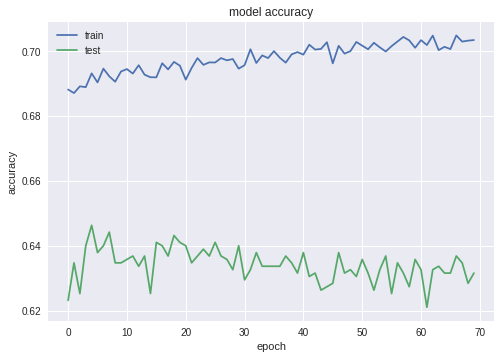

In [49]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
model.save_weights('gdrive/Seedling/Best_weights.h5')

In [0]:
# x_test = np.load('gdrive/Seedling/X_test.npy')

In [21]:
preds = model.predict(X_test, verbose=1)

794/794 [==============================] - 1s 2ms/step


In [22]:
sub = pd.DataFrame(preds)
# Set column names to those generated by the one-hot encoding earlier
col_names = one_hot.columns.values
sub.columns = col_names
# Insert the column id from the sample_submission at the start of the data frame
sub.insert(0, 'id', df_test['id'])
sub.head(5)

NameError: ignored

In [0]:
%%time
sub.to_csv("gdrive/Seedling/Dog_Submission7.csv", index=False, header=True)

CPU times: user 1.93 s, sys: 148 ms, total: 2.08 s
Wall time: 15.9 s


In [0]:
model.save_weights('drive/Toxic_Comment/my_doggie_weights.h5')